### Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import signal
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from loess.loess_1d import loess_1d
from statsmodels.nonparametric.smoothers_lowess import lowess
from tvregdiff import TVRegDiff
import pandas as pd

### User Defined Functions

In [2]:
def create_exp(N, A, B):
    expo = A*np.exp(-B*np.arange(0,N))
    return expo
def create_lin(N, a, b):
    lin = a*np.arange(0,N) + b
    return lin
def concat_noise(C, m = 0, s = 1):
    # import numpy as np
    concat = []
    for c in C:
        concat.extend(c)
    X = np.arange(0,len(concat))
    Y = concat +  np.random.normal(loc=m, scale=s, size=len(concat))
    return X, Y

def RMSE(Ypred, Yreal):
    rmse = np.sqrt(np.sum(np.square(Ypred-Yreal))/np.shape(Ypred)[0])
    return rmse
def fit_and_pred(X, y):
    Xarr = np.array(X).reshape(-1,1)
    yarr = np.array(y).reshape(-1,1)
    reg = LinearRegression().fit(Xarr, yarr)
    pred = reg.predict(Xarr)
    rmse = RMSE(pred, yarr)
    return rmse
def sliding_window_pred(X, y, window, lag):
    Xmax = np.shape(X)[0]-window+1
    start = np.arange(0, Xmax, lag)
    mean_start = X[[int(s + window/2) for s in start]]
    score = [fit_and_pred(X[s:s+window], y[s:s+window]) 
            for s in start]    
    return score, mean_start

### Generate exp and linear parts of the data

In [3]:
expo = create_exp(N = 15000, A = 10 , B = 0.0001)
lin = create_lin(N = 15000, a = -0.00005 , b = expo[-1]-0.01*expo[-1])
print(expo)
print(lin)

[10.          9.99900005  9.9980002  ...  2.23197109  2.23174791
  2.23152474]
[2.2092095 2.2091595 2.2091095 ... 1.4593595 1.4593095 1.4592595]


### Data with weak noise

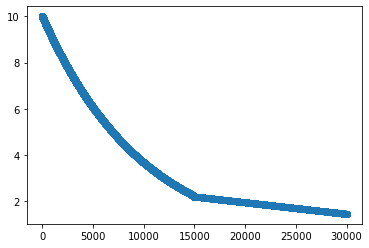

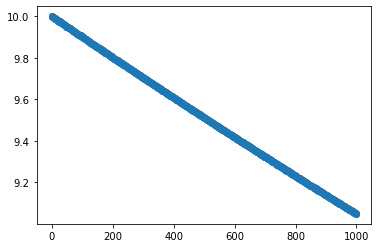

In [13]:
# %% low noise
X, Y = concat_noise(C = [expo,lin], m = 0, s = 0.001)

plt.scatter(X,Y)
plt.show()
plt.scatter(X[0:1000],Y[0:1000])
plt.show()

### Implementation of the algorithm and diagnostic plots

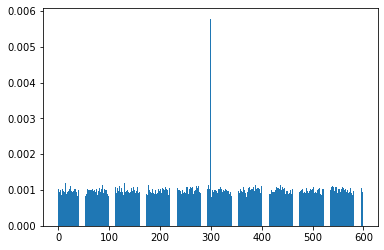

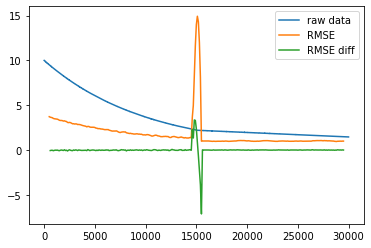

In [83]:
score,_ = sliding_window_pred(X = X, y = Y,
                            window = 100, 
                            lag = 50)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.show()


# %%
score,Xscore = sliding_window_pred(X = X, y = Y, 
                            window = 1000, 
                            lag = 100)
plt.plot(X,Y, label = 'raw data')
plt.plot(Xscore,np.array(score)*1000, label = 'RMSE') # amplified in order to have similar scale with raw signal
plt.plot(Xscore[1:],np.diff(score)*1000, label = 'RMSE diff')
plt.legend()
plt.show()

### More Noisy Data

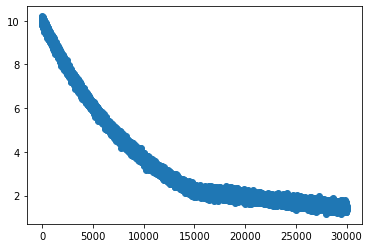

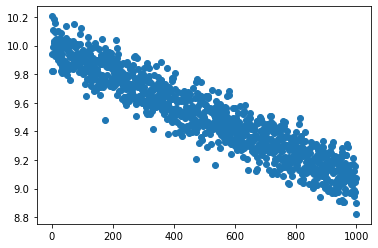

In [85]:
# %% more noisy data
X, Y = concat_noise(C = [expo,lin], m = 0, s = 0.1)

# %%
plt.scatter(X,Y)
plt.show()

plt.scatter(X[0:1000],Y[0:1000])
plt.show()

#### GridSearch for assessing the best combination of hyperparameters (window, lag)

In [27]:
for i in [2111, 3111, 4811, 5877, 6854]:
    for j in [11, 59, 111, 337, 511, 777]:
        score,_  = sliding_window_pred(X = X, y = Y, 
                                    window = i, 
                                    lag = j)
        deltascore = np.round(np.max(np.diff(score))/0.001,3)
        print("\n for window : {} and lag : {} \n delta max diff score is : {}".format(i, j, deltascore))



 for window : 2111 and lag : 11 
 delta max diff score is : 0.435

 for window : 2111 and lag : 59 
 delta max diff score is : 2.276

 for window : 2111 and lag : 111 
 delta max diff score is : 4.163

 for window : 2111 and lag : 337 
 delta max diff score is : 12.239

 for window : 2111 and lag : 511 
 delta max diff score is : 15.627

 for window : 2111 and lag : 777 
 delta max diff score is : 20.396

 for window : 3111 and lag : 11 
 delta max diff score is : 0.416

 for window : 3111 and lag : 59 
 delta max diff score is : 2.199

 for window : 3111 and lag : 111 
 delta max diff score is : 4.125

 for window : 3111 and lag : 337 
 delta max diff score is : 11.755

 for window : 3111 and lag : 511 
 delta max diff score is : 18.053

 for window : 3111 and lag : 777 
 delta max diff score is : 22.204

 for window : 4811 and lag : 11 
 delta max diff score is : 0.383

 for window : 4811 and lag : 59 
 delta max diff score is : 2.036

 for window : 4811 and lag : 111 
 delta max di

### Implementation of the algorithm and diagnostic plots

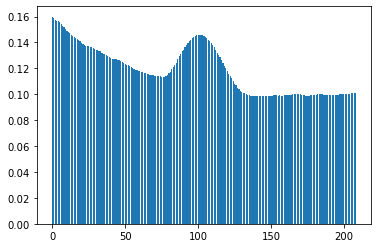

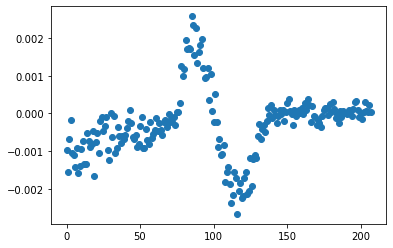

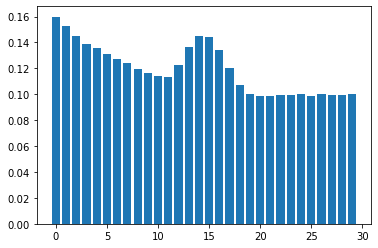

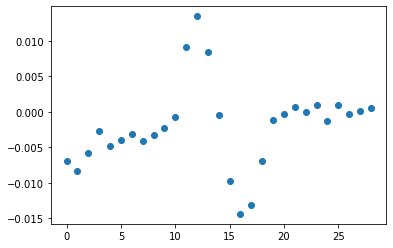

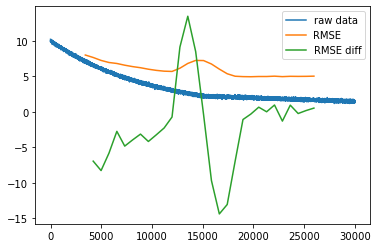

In [90]:
score,_  = sliding_window_pred(X = X, y = Y, 
                            window = 6854, 
                            lag = 111)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.show()



plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
plt.show()

# %%
score,Xscore  = sliding_window_pred(X = X, y = Y, 
                            window = 6854, 
                            lag = 777)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.show()

plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
plt.show()


plt.plot(X,Y, label = 'raw data')
plt.plot(Xscore,np.array(score)*50, label = 'RMSE') # amplified in order to have similar scale with raw signal
plt.plot(Xscore[1:],np.diff(score)*1000, label = 'RMSE diff')
plt.legend()
plt.show()


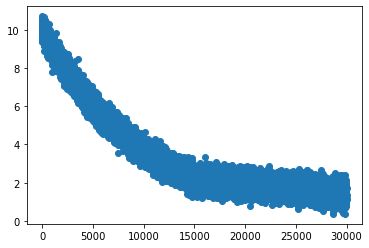

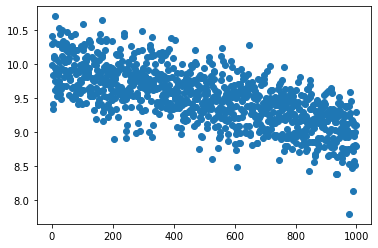

In [91]:
# %% still more noisy data
X, Y = concat_noise(C = [expo,lin], m = 0, s = 0.3)

# %%
plt.scatter(X,Y)
plt.show()

plt.scatter(X[0:1000],Y[0:1000])
plt.show()


#### GridSearch for assessing the best combination of hyperparameters (window, lag)

In [22]:
for i in [2111, 3111, 4811, 5877, 6854]:
    for j in [11, 59, 111, 337, 511, 777, 1279, 2447]:
        score,_  = sliding_window_pred(X = X, y = Y, 
                                    window = i, 
                                    lag = j)
        deltascore = np.round(np.max(np.diff(score)-np.mean(np.diff(score)))/0.001,3)
        print("\n for window : {} and lag : {} \n delta max diff score is : {}".format(i, j, deltascore))



 for window : 2111 and lag : 11 
 delta max diff score is : 1.765

 for window : 2111 and lag : 59 
 delta max diff score is : 3.091

 for window : 2111 and lag : 111 
 delta max diff score is : 3.667

 for window : 2111 and lag : 337 
 delta max diff score is : 7.283

 for window : 2111 and lag : 511 
 delta max diff score is : 5.881

 for window : 2111 and lag : 777 
 delta max diff score is : 8.414

 for window : 2111 and lag : 1279 
 delta max diff score is : 9.122

 for window : 2111 and lag : 2447 
 delta max diff score is : 11.48

 for window : 3111 and lag : 11 
 delta max diff score is : 1.285

 for window : 3111 and lag : 59 
 delta max diff score is : 2.736

 for window : 3111 and lag : 111 
 delta max diff score is : 2.347

 for window : 3111 and lag : 337 
 delta max diff score is : 4.541

 for window : 3111 and lag : 511 
 delta max diff score is : 4.634

 for window : 3111 and lag : 777 
 delta max diff score is : 4.966

 for window : 3111 and lag : 1279 
 delta max dif

### Implementation of the algorithm and diagnostic plots

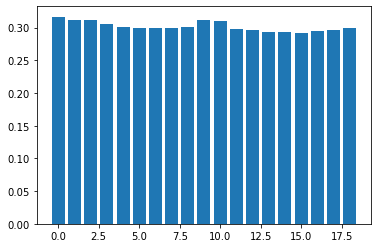

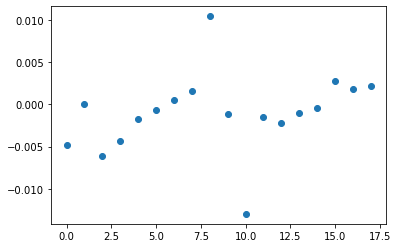

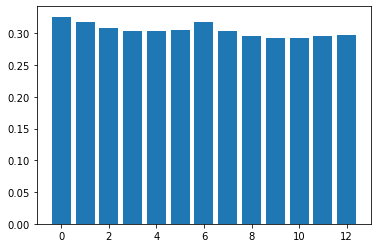

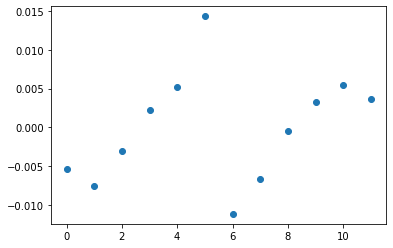

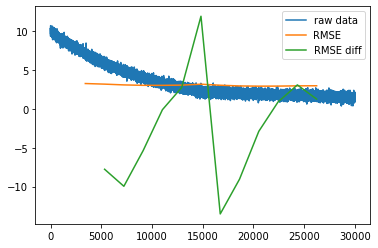

In [99]:
score,_  = sliding_window_pred(X = X, y = Y, 
                            window = 5877, 
                            lag = 1279)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.show()



plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
plt.show()

# %%
score,Xscore  = sliding_window_pred(X = X, y = Y, 
                            window = 6854, 
                            lag = 1900)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.show()

plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score)-np.mean(np.diff(score)))
plt.show()


plt.plot(X,Y, label = 'raw data')
plt.plot(Xscore,np.array(score)*10, label = 'RMSE') # amplified in order to have similar scale with raw signal
plt.plot(Xscore[1:],np.diff(score)*1000, label = 'RMSE diff')
plt.legend()
plt.show()


# Smoothing noisy signal

###  Savgol filter

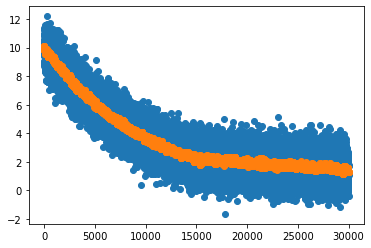

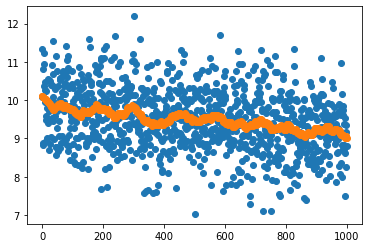

In [100]:
X, Y = concat_noise(C = [expo,lin], m = 0, s = 0.8)
Ysmooth = signal.savgol_filter(Y, 53, 1)

 # %%
plt.scatter(X,Y)
plt.scatter(X,Ysmooth)
plt.show()

plt.scatter(X[0:1000],Y[0:1000])
plt.scatter(X[0:1000],Ysmooth[0:1000])
plt.show()

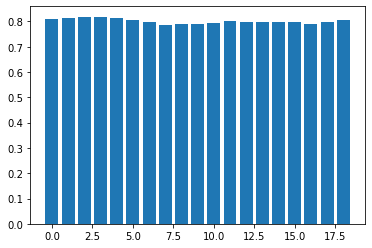

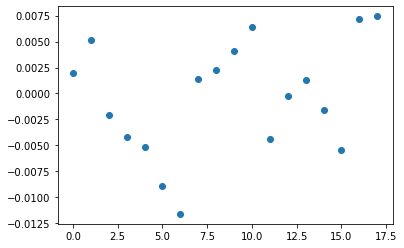

In [6]:
# %%
score,_  = sliding_window_pred(X = X, y = Y, 
                            window = 5877, 
                            lag = 1279)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.title('No smoothing')
plt.show()
plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
plt.title('No smoothing')
plt.show()

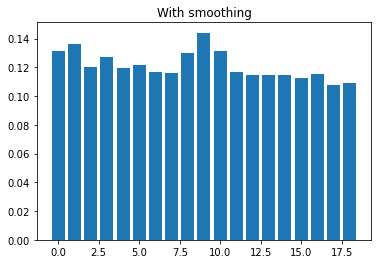

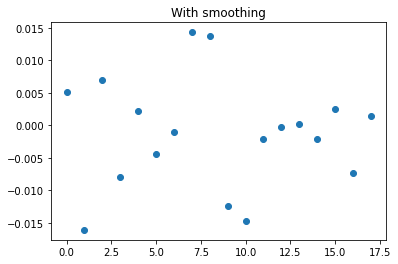

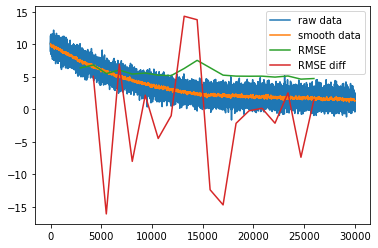

In [105]:
score,Xscore = sliding_window_pred(X = X, y = Ysmooth, 
                            window = 5877, 
                            lag = 1279)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.title('With smoothing')
plt.show()
plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
plt.title('With smoothing')
plt.show()

plt.plot(X,Y, label = 'raw data')
plt.plot(X, Ysmooth, label = 'smooth data')
plt.plot(Xscore,(1+np.array(score))**15, label = 'RMSE') # amplified in order to have similar scale with raw signal
plt.plot(Xscore[1:],np.diff(score)*1000, label = 'RMSE diff')
plt.legend()
plt.show()

## Convolution smoothing

In [106]:
# %%
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    
    
    https://scipy.github.io/old-wiki/pages/Cookbook/SignalSmooth.html
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [107]:
#%%
X, Y = concat_noise(C = [expo,lin], m = 0, s = 0.8)
Ysmooth = smooth(Y,window_len=150,window='hamming')[0:30000]

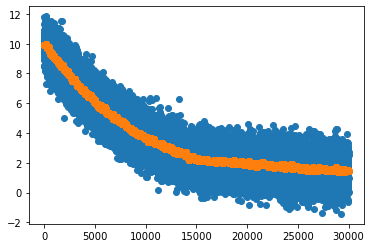

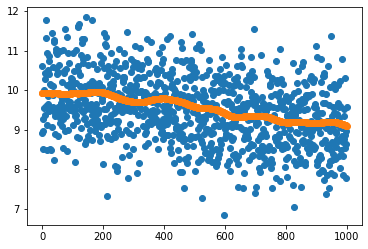

In [108]:
 # %%
plt.scatter(X,Y)
plt.scatter(X,Ysmooth)
plt.show()

plt.scatter(X[0:1000],Y[0:1000])
plt.scatter(X[0:1000],Ysmooth[0:1000])
plt.show()

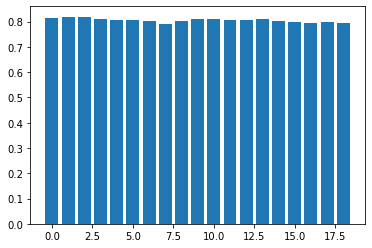

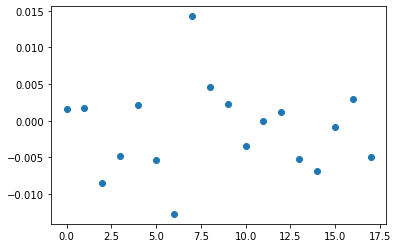

In [11]:
# %% 
score,_  = sliding_window_pred(X = X, y = Y, 
                            window = 5877, 
                            lag = 1279)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.title('No smoothing')
plt.show()
plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
plt.title('No smoothing')
plt.show()

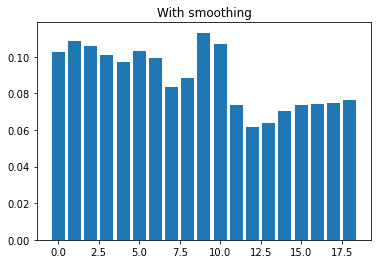

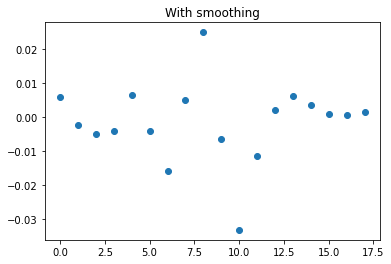

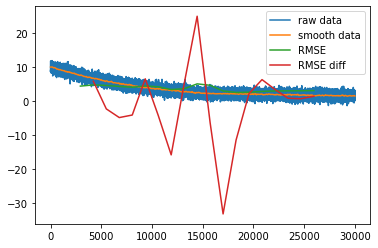

In [109]:
score,Xscore  = sliding_window_pred(X = X, y = Ysmooth, 
                            window = 5877, 
                            lag = 1279)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.title('With smoothing')
plt.show()
plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
plt.title('With smoothing')
plt.show()

plt.plot(X,Y, label = 'raw data')
plt.plot(X, Ysmooth, label = 'smooth data')
plt.plot(Xscore,(1+np.array(score))**15, label = 'RMSE') # amplified in order to have similar scale with raw signal
plt.plot(Xscore[1:],np.diff(score)*1000, label = 'RMSE diff')
plt.legend()
plt.show()

## Loess smoothing

In [110]:
X, Y = concat_noise(C = [expo,lin], m = 0, s = 0.8)

# delta & frac : hyperparameters for adjusting smoothing

Ysmooth = lowess(exog = X, endog = Y, frac = 0.01, delta = 0.001 * X.shape[0], return_sorted = False)

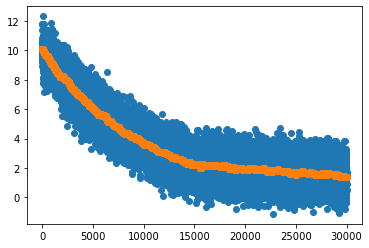

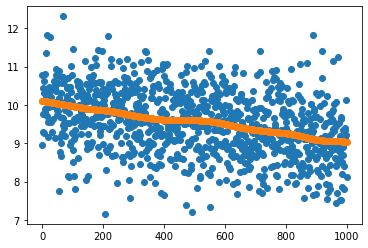

In [111]:
plt.scatter(X,Y)
plt.scatter(X,Ysmooth)
plt.show()

plt.scatter(X[0:1000],Y[0:1000])
plt.scatter(X[0:1000],Ysmooth[0:1000])
plt.show()

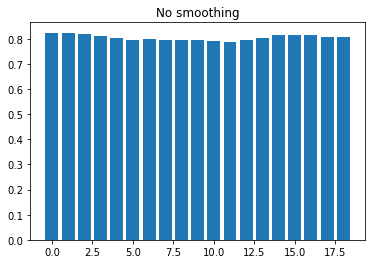

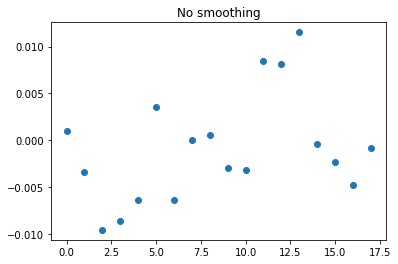

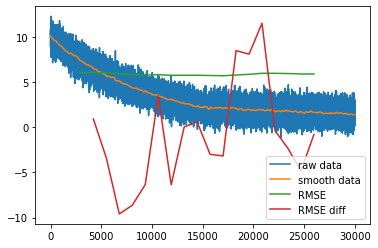

In [120]:
# %% 
score,Xscore  = sliding_window_pred(X = X, y = Y, 
                            window = 5877, 
                            lag = 1279)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.title('No smoothing')
plt.show()
plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
plt.title('No smoothing')
plt.show()

plt.plot(X,Y, label = 'raw data')
plt.plot(X, Ysmooth, label = 'smooth data')
plt.plot(Xscore,(1+np.array(score))**3, label = 'RMSE') # amplified in order to have similar scale with raw signal
plt.plot(Xscore[1:],np.diff(score)*1000, label = 'RMSE diff')
plt.legend()
plt.show()

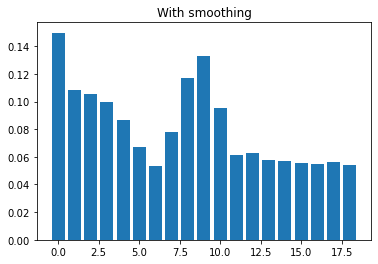

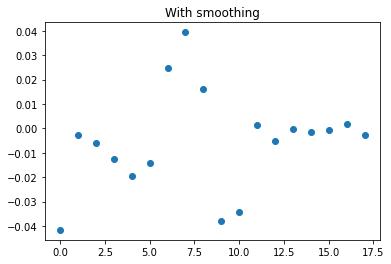

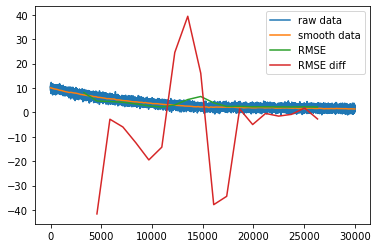

In [112]:
score,Xscore  = sliding_window_pred(X = X, y = Ysmooth, 
                            window = 6587, 
                            lag = 1279)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.title('With smoothing')
plt.show()
plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
plt.title('With smoothing')
plt.show()

plt.plot(X,Y, label = 'raw data')
plt.plot(X, Ysmooth, label = 'smooth data')
plt.plot(Xscore,(1+np.array(score))**15, label = 'RMSE') # amplified in order to have similar scale with raw signal
plt.plot(Xscore[1:],np.diff(score)*1000, label = 'RMSE diff')
plt.legend()
plt.show()

## Gaussian Process Regressor

**NB : Not working yet, need to find the optimal kernel**

In [ ]:
# # %%
# X, Y = concat_noise(C = [expo,lin], m = 0, s = 0.8)
# k1 = 1.0*RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))  # long term smooth rising trend
# k4 = WhiteKernel(noise_level=1e-1)  # noise terms
# kernel_gpml = k1 + k4
# gpr = GaussianProcessRegressor(kernel = kernel_gpml, random_state=0).fit(X.reshape(-1,1), Y.reshape(-1,1))
# Ysmooth= gpr.predict(X.reshape(-1,1), return_std=True)

In [ ]:
# %%
# plt.scatter(X,Y)
# plt.scatter(X,Ysmooth)
# plt.show()

# plt.scatter(X[0:1000],Y[0:1000])
# plt.scatter(X[0:1000],Ysmooth[0:1000])
# plt.show()

In [ ]:
# %%
# score = sliding_window_pred(X = X, y = Y, 
#                             window = 5877, 
#                             lag = 1279)
# plt.bar(np.arange(0,np.shape(score)[0]),score)
# plt.show()
# plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
# plt.show()

In [ ]:
# score = sliding_window_pred(X = X, y = Ysmooth, 
#                             window = 5877, 
#                             lag = 1279)
# plt.bar(np.arange(0,np.shape(score)[0]),score)
# plt.show()
# plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
# plt.show()

# Test on real data

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('/home/xavier/Documents/development/time series_dehydration.csv', sep = ",")
df.head()

,time_min,LituBD5_mass,LituLD2_mass,LituBL2t_mass,LituLL21_mass
0,0,10.1939,2.6558,8.630007,2.2994
1,4,10.1389,2.6687,8.433729,2.2472
2,8,10.0182,2.5720,8.425646,2.2357
3,12,10.0514,2.6448,8.081766,2.2573
4,16,10.1963,2.6695,8.018859,2.2242


In [7]:
df.shape

(1132, 5)

In [5]:
col = [c for c in df.columns if c != 'time_min']
print(col)

['LituBD5_mass', 'LituLD2_mass', 'LituBL2t_mass', 'LituLL21_mass']


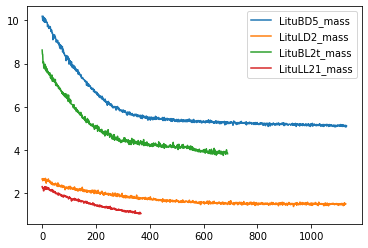

In [9]:
df[col].plot()

test for LituBD5_mass -------------------------------


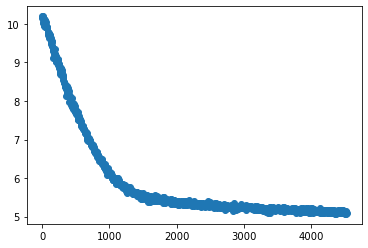

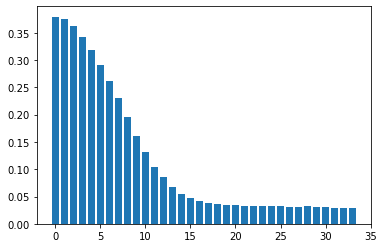

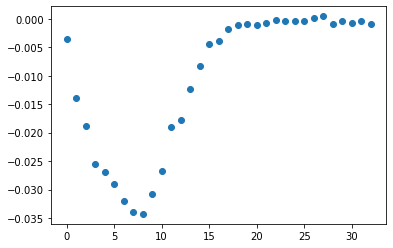

test for LituLD2_mass -------------------------------


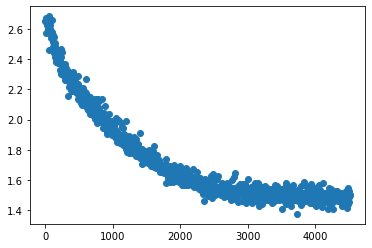

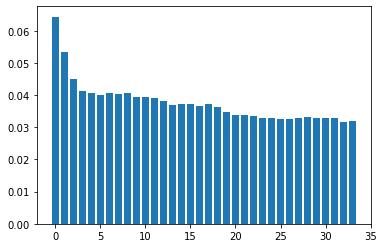

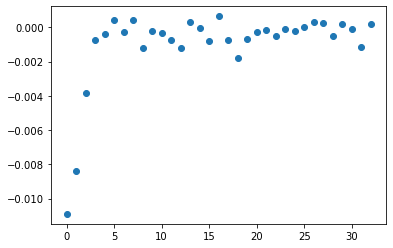

test for LituBL2t_mass -------------------------------


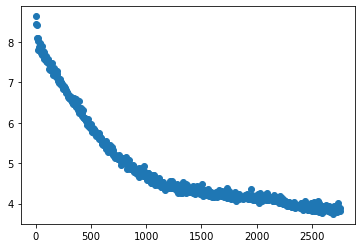

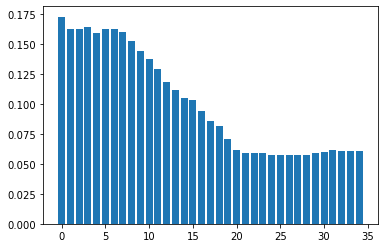

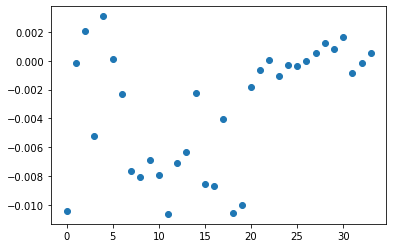

test for LituLL21_mass -------------------------------


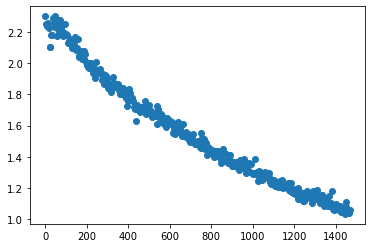

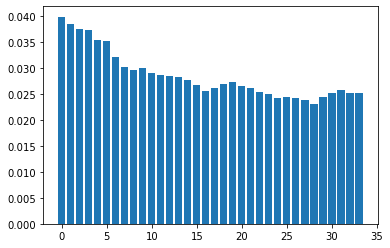

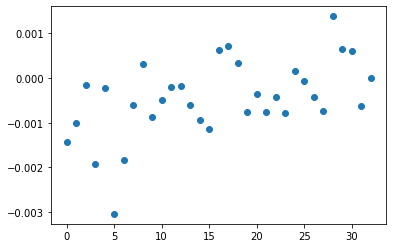

In [126]:
for c in col:
    
    print('test for {} -------------------------------'.format(c))
    df2 = df[['time_min', c]].dropna(subset = [c])

    score,_  = sliding_window_pred(X = df2['time_min'].values, y = df2[c].values, 
                                window = int(df2[c].shape[0]/2.8),
                                lag = int(df2[c].shape[0]/50))
    plt.scatter(x=df2['time_min'].values, y = df2[c].values)
    plt.show()
    plt.bar(np.arange(0,np.shape(score)[0]),score)
    plt.show()
    plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
    plt.show()

test for LituBD5_mass -------------------------------


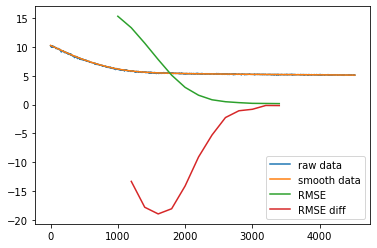

test for LituLD2_mass -------------------------------


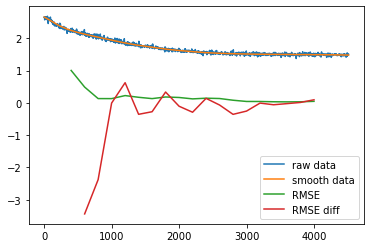

test for LituBL2t_mass -------------------------------


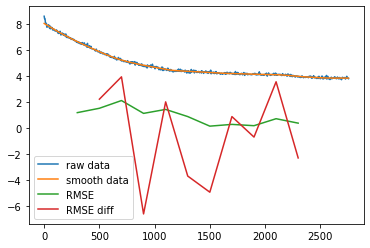

test for LituLL21_mass -------------------------------


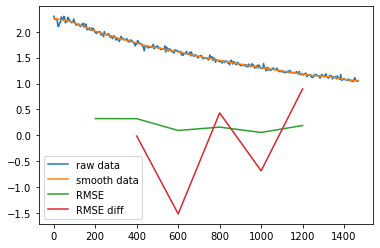

In [164]:
W = [500,200,150,100]
L = [50,50,50,50]
i = 0
for c in col:
    
    print('test for {} -------------------------------'.format(c))
    df2 = df[['time_min', c]].dropna(subset = [c])
    
    Ysmooth = lowess(exog = df2['time_min'].values, endog = df2[c].values, frac = 0.1, delta = 0.1 * df2['time_min'].shape[0], return_sorted = False)
    score, Xscore = sliding_window_pred(X = df2['time_min'].values, y = Ysmooth, 
                                window = W[i],
                                lag = L[i])    
 
    i+=1
    
    plt.plot(df2['time_min'].values, df2[c].values, label = 'raw data')
    plt.plot(df2['time_min'].values, Ysmooth, label = 'smooth data')
    plt.plot(Xscore,np.array(score)*30, label = 'RMSE')
    plt.plot(Xscore[1:],np.diff(score)*200, label = 'RMSE diff')
    plt.legend()
    plt.show()

In [163]:
# ['LituBD5_mass', 'LituLD2_mass', 'LituBL2t_mass', 'LituLL21_mass']
c = 'LituBD5_mass'
for i in [10, 50, 100, 150, 200, 250, 500]:
    for j in [1, 5 ,10, 20, 50]:
        df2 = df[['time_min', c]].dropna(subset = [c])
        
        Ysmooth = lowess(exog = df2['time_min'].values, endog = df2[c].values, frac = 0.1, \
                         delta = 0.1 * df2['time_min'].shape[0], return_sorted = False)
        
        score, Xscore = sliding_window_pred(X = df2['time_min'].values, y = Ysmooth, 
                                            window = i, lag = j)
        
        deltascore = np.round(np.max(np.diff(score)-np.mean(np.diff(score)))/0.001,3)
        
        print("\n for window : {} and lag : {} \n delta max diff score is : {}".format(i, j, deltascore))



 for window : 10 and lag : 1 
 delta max diff score is : 0.502

 for window : 10 and lag : 5 
 delta max diff score is : 0.735

 for window : 10 and lag : 10 
 delta max diff score is : 0.517

 for window : 10 and lag : 20 
 delta max diff score is : 0.638

 for window : 10 and lag : 50 
 delta max diff score is : 0.523

 for window : 50 and lag : 1 
 delta max diff score is : 0.39

 for window : 50 and lag : 5 
 delta max diff score is : 1.748

 for window : 50 and lag : 10 
 delta max diff score is : 3.338

 for window : 50 and lag : 20 
 delta max diff score is : 3.783

 for window : 50 and lag : 50 
 delta max diff score is : 4.332

 for window : 100 and lag : 1 
 delta max diff score is : 0.341

 for window : 100 and lag : 5 
 delta max diff score is : 1.575

 for window : 100 and lag : 10 
 delta max diff score is : 3.028

 for window : 100 and lag : 20 
 delta max diff score is : 4.472

 for window : 100 and lag : 50 
 delta max diff score is : 5.369

 for window : 150 and lag 

# Derivate a noisy signal

https://stackoverflow.com/questions/15862066/gradient-in-noisy-data-python
https://github.com/stur86/tvregdiff

In [72]:
from tvregdiff import TVRegDiff

In [ ]:
# u = TVRegDiff(data, iter, alph, u0, scale, ep, dx, plotflag,
# diagflag, precondflag, diffkernel, cgtol, cgmaxit)

## Simulated data

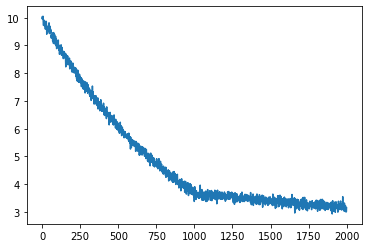

In [324]:
# expo = create_exp(N = 100, A = 10 , B = 0.001)
# lin = create_lin(N = 100, a = -0.0005 , b = expo[-1]-0.01*expo[-1])
expo = create_exp(N = 1000, A = 10 , B = 0.001)
lin = create_lin(N = 1000, a = -0.0005 , b = expo[-1]-0.01*expo[-1])
X, Y = concat_noise(C = [expo,lin], m = 0, s = 0.1)
plt.plot(X, Y )
plt.show()

In [328]:
print('\n-------------------  without smoother')
dX = X[1] - X[0]

dYdX = TVRegDiff(data=Y ,itern=20, 
                 alph=10, dx=dX, 
                 ep=1e-9,
                 scale='small' ,
                 plotflag=False, 
                 precondflag=False,
                 diffkernel='abs',
                 cgtol = 1e-4)


-------------------  without smoother


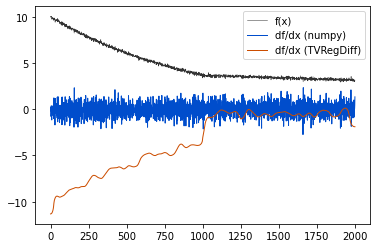

In [329]:
plt.plot(X, Y, label='f(x)', c=(0.2, 0.2, 0.2), lw=0.5)
plt.plot(X, np.gradient(Y, dX)*10,
         label='df/dx (numpy)', c=(0, 0.3, 0.8), lw=1)
plt.plot(X, dYdX*1000, label='df/dx (TVRegDiff)',
         c=(0.8, 0.3, 0.0), lw=1)
plt.legend()
plt.show()


-------------------  with smoother


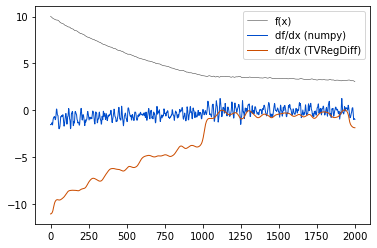

In [330]:
print('\n-------------------  with smoother')
Y = lowess(exog = X, endog = Y, frac = 0.01, delta = 0.001 * X.shape[0], return_sorted = False)
dYdX = TVRegDiff(data=Y ,itern=20, 
                 alph=10, dx=dX, 
                 ep=1e-9,
                 scale='small' ,
                 plotflag=False, 
                 precondflag=False,
                 diffkernel='abs',
                 cgtol = 1e-4)

plt.plot(X, Y, label='f(x)', c=(0.2, 0.2, 0.2), lw=0.5)
plt.plot(X, np.gradient(Y, dX)*100,
         label='df/dx (numpy)', c=(0, 0.3, 0.8), lw=1)
plt.plot(X, dYdX*1000, label='df/dx (TVRegDiff)',
         c=(0.8, 0.3, 0.0), lw=1)
plt.legend()
plt.show()


##  Real data


------------------- test for : LituBD5_mass


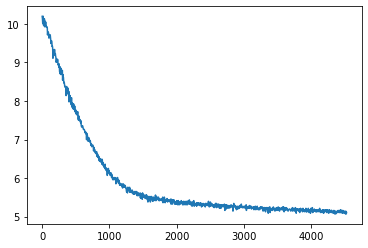


-------------------  without smoother


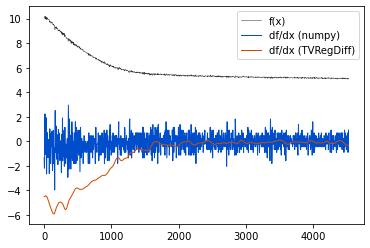


-------------------  with smoother
[-0.00298493 -0.002992   -0.0030134  ... -0.00029845 -0.00029868
 -0.0002987 ]


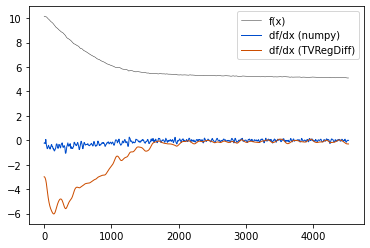

In [8]:
c = ['LituBD5_mass', 'LituLD2_mass', 'LituBL2t_mass', 'LituLL21_mass'][0]

print('\n------------------- test for : {}'.format(c))
X = df[['time_min', c]].dropna(subset = [c])['time_min'].values
Y = df[['time_min', c]].dropna(subset = [c])[c].values
plt.plot(X, Y )
plt.show()
dX = X[1] - X[0]


print('\n-------------------  without smoother')
dYdX = TVRegDiff(data=Y ,itern=20, 
                 alph=10, dx=dX, 
                 ep=1e-9,
                 scale='small' ,
                 plotflag=False, 
                 precondflag=False,
                 diffkernel='abs',
                 cgtol = 1e-4)

plt.plot(X, Y, label='f(x)', c=(0.2, 0.2, 0.2), lw=0.5)
plt.plot(X, np.gradient(Y, dX)*100,
         label='df/dx (numpy)', c=(0, 0.3, 0.8), lw=1)
plt.plot(X, dYdX*1000, label='df/dx (TVRegDiff)',
         c=(0.8, 0.3, 0.0), lw=1)
plt.legend()
plt.show()


print('\n-------------------  with smoother')
Y = lowess(exog = X, endog = Y, frac = 0.01, delta = 0.001 * X.shape[0], return_sorted = False)
dYdX = TVRegDiff(data=Y ,itern=20, 
                 alph=10, dx=dX, 
                 ep=1e-9,
                 scale='small' ,
                 plotflag=False, 
                 precondflag=False,
                 diffkernel='abs',
                 cgtol = 1e-4)
print(dYdX)
plt.plot(X, Y, label='f(x)', c=(0.2, 0.2, 0.2), lw=0.5)
plt.plot(X, np.gradient(Y, dX)*100,
         label='df/dx (numpy)', c=(0, 0.3, 0.8), lw=1)
plt.plot(X, dYdX*1000, label='df/dx (TVRegDiff)',
         c=(0.8, 0.3, 0.0), lw=1)
plt.legend()
plt.show()




------------------- test for : LituLD2_mass


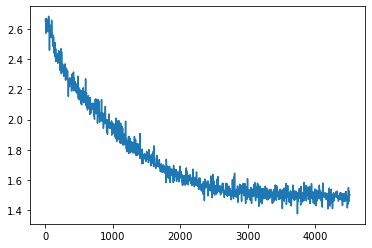


-------------------  without smoother


[-1.25833617e-03 -1.25830675e-03 -1.25821396e-03 ... -1.96847908e-05
 -1.96651477e-05 -1.96627372e-05]


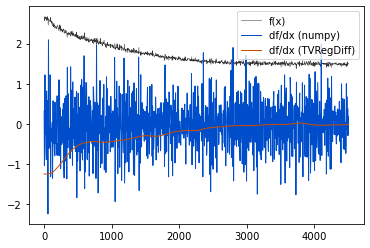


-------------------  with smoother


[-1.21811261e-03 -1.21805308e-03 -1.21787452e-03 ... -2.73953279e-05
 -2.73952363e-05 -2.73952240e-05]


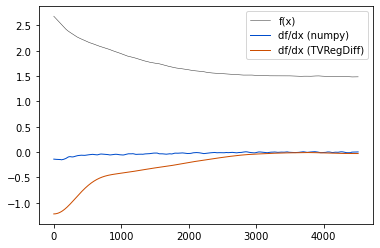

In [15]:
c = ['LituBD5_mass', 'LituLD2_mass', 'LituBL2t_mass', 'LituLL21_mass'][1]
print('\n------------------- test for : {}'.format(c))

X = df[['time_min', c]].dropna(subset = [c])['time_min'].values
Y = df[['time_min', c]].dropna(subset = [c])[c].values
plt.plot(X, Y )
plt.show()
dX = X[1] - X[0]


print('\n-------------------  without smoother')
dYdX = TVRegDiff(data=Y ,itern=20, 
                 alph=1000, dx=dX, 
                 ep=1e-9,
                 scale='small' ,
                 plotflag=False, 
                 precondflag=False,
                 diffkernel='abs',
                 cgtol = 1e-4)
print(dYdX)
plt.plot(X, Y, label='f(x)', c=(0.2, 0.2, 0.2), lw=0.5)
plt.plot(X, np.gradient(Y, dX)*100,
         label='df/dx (numpy)', c=(0, 0.3, 0.8), lw=1)
plt.plot(X, dYdX*1000, label='df/dx (TVRegDiff)',
         c=(0.8, 0.3, 0.0), lw=1)
plt.legend()
plt.show()


print('\n-------------------  with smoother')
Y = lowess(exog = X, endog = Y, frac = 0.05, delta = 0.001 * X.shape[0], return_sorted = False)
dYdX = TVRegDiff(data=Y ,itern=20, 
                 alph=10000, dx=dX, 
                 ep=1e-9,
                 scale='small' ,
                 plotflag=False, 
                 precondflag=False,
                 diffkernel='abs',
                 cgtol = 1e-4)
print(dYdX)

plt.plot(X, Y, label='f(x)', c=(0.2, 0.2, 0.2), lw=0.5)
plt.plot(X, np.gradient(Y, dX)*100,
         label='df/dx (numpy)', c=(0, 0.3, 0.8), lw=1)
plt.plot(X, dYdX*1000, label='df/dx (TVRegDiff)',
         c=(0.8, 0.3, 0.0), lw=1)
plt.legend()
plt.show()




------------------- test for : LituBL2t_mass

-------------------  without smoother


[-1.67761189e-02 -1.67642764e-02 -1.67281689e-02 -1.66648146e-02
 -1.65688100e-02 -1.64310291e-02 -1.61354451e-02 -1.57117243e-02
 -1.52471533e-02 -1.46142225e-02 -1.33716412e-02 -1.23212757e-02
 -1.01341052e-02 -8.98585436e-03 -8.28618382e-03 -7.74471945e-03
 -7.30514408e-03 -6.93498075e-03 -6.61516327e-03 -6.35661966e-03
 -6.12980746e-03 -5.93039751e-03 -5.75335943e-03 -5.59416912e-03
 -5.44909185e-03 -5.31707628e-03 -5.19757255e-03 -5.08985899e-03
 -4.99280992e-03 -4.90435107e-03 -4.82286145e-03 -4.74759238e-03
 -4.67853105e-03 -4.61554478e-03 -4.55850782e-03 -4.50760572e-03
 -4.46273405e-03 -4.42295903e-03 -4.38703347e-03 -4.35524585e-03
 -4.32799626e-03 -4.30505479e-03 -4.28578675e-03 -4.26917054e-03
 -4.25479782e-03 -4.24278186e-03 -4.23265521e-03 -4.22401328e-03
 -4.21695690e-03 -4.21108820e-03 -4.20519743e-03 -4.19876330e-03
 -4.19186335e-03 -4.18462272e-03 -4.17748120e-03 -4.17025369e-03
 -4.16283171e-03 -4.15543211e-03 -4.14793253e-03 -4.14023918e-03
 -4.13230658e-03 -4.12379

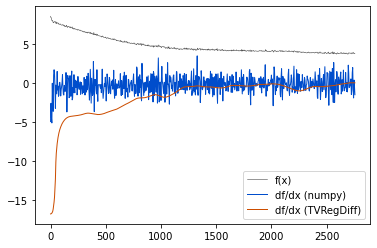


-------------------  with smoother


[-1.66514681e-02 -1.66393389e-02 -1.66020892e-02 -1.65369279e-02
 -1.64383465e-02 -1.62962578e-02 -1.60919488e-02 -1.48905220e-02
 -1.43812749e-02 -1.31585464e-02 -1.15744870e-02 -1.06357080e-02
 -9.96198857e-03 -9.22401906e-03 -8.67715149e-03 -8.19234043e-03
 -7.76903811e-03 -7.36496266e-03 -7.02837943e-03 -6.73200561e-03
 -6.46250244e-03 -6.22820364e-03 -6.01934298e-03 -5.83203064e-03
 -5.66306878e-03 -5.51035880e-03 -5.37251167e-03 -5.24809997e-03
 -5.13547441e-03 -5.03296067e-03 -4.93912168e-03 -4.85295967e-03
 -4.77390492e-03 -4.70167634e-03 -4.63612419e-03 -4.57712839e-03
 -4.52448157e-03 -4.47779792e-03 -4.43661707e-03 -4.40047614e-03
 -4.36896339e-03 -4.34163849e-03 -4.31791817e-03 -4.29720044e-03
 -4.27902785e-03 -4.26312609e-03 -4.24935438e-03 -4.23756937e-03
 -4.22751295e-03 -4.21877858e-03 -4.21090757e-03 -4.20352795e-03
 -4.19649100e-03 -4.18984309e-03 -4.18365059e-03 -4.17796740e-03
 -4.17279860e-03 -4.16810758e-03 -4.16384764e-03 -4.15990175e-03
 -4.15610145e-03 -4.15233

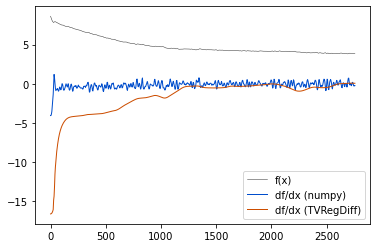

[-3.69831731e-03 -3.68131904e-03 -3.66465506e-03 -3.64863496e-03
 -3.63334626e-03 -3.61865405e-03 -3.60440358e-03 -3.59056913e-03
 -3.57717614e-03 -3.56418938e-03 -3.55151367e-03 -3.53910897e-03
 -3.52707164e-03 -3.51556460e-03 -3.50467814e-03 -3.49435113e-03
 -3.48439873e-03 -3.47447799e-03 -3.46406804e-03 -3.45258625e-03
 -3.43950856e-03 -3.42444315e-03 -3.40711461e-03 -3.38733309e-03
 -3.36500177e-03 -3.34017473e-03 -3.31304247e-03 -3.28384976e-03
 -3.25283853e-03 -3.22019768e-03 -3.18606366e-03 -3.15055160e-03
 -3.11383241e-03 -3.07618489e-03 -3.03793865e-03 -2.99938552e-03
 -2.96073409e-03 -2.92217623e-03 -2.88401592e-03 -2.84665089e-03
 -2.81045044e-03 -2.77565431e-03 -2.74232161e-03 -2.71038705e-03
 -2.67968718e-03 -2.64991763e-03 -2.62065196e-03 -2.59141524e-03
 -2.56176703e-03 -2.53146798e-03 -2.50054014e-03 -2.46913456e-03
 -2.43739390e-03 -2.40537838e-03 -2.37314260e-03 -2.34082672e-03
 -2.30864019e-03 -2.27674509e-03 -2.24519468e-03 -2.21402179e-03
 -2.18333679e-03 -2.15334

In [18]:
c = ['LituBD5_mass', 'LituLD2_mass', 'LituBL2t_mass', 'LituLL21_mass'][2]
print('\n------------------- test for : {}'.format(c))

X = df[['time_min', c]].dropna(subset = [c])['time_min'].values
Y = df[['time_min', c]].dropna(subset = [c])[c].values
# plt.plot(X, Y )
# plt.show()
dX = X[1] - X[0]



print('\n-------------------  without smoother')
dYdX = TVRegDiff(data=Y ,itern=20, 
                 alph=50, dx=dX, 
                 ep=1e-9,
                 scale='small' ,
                 plotflag=False, 
                 precondflag=False,
                 diffkernel='abs',
                 cgtol = 1e-4)
print(dYdX)
plt.plot(X, Y, label='f(x)', c=(0.2, 0.2, 0.2), lw=0.5)
plt.plot(X, np.gradient(Y, dX)*100,
         label='df/dx (numpy)', c=(0, 0.3, 0.8), lw=1)
plt.plot(X, dYdX*1000, label='df/dx (TVRegDiff)',
         c=(0.8, 0.3, 0.0), lw=1)
plt.legend()
plt.show()


print('\n-------------------  with smoother')
Y = lowess(exog = X, endog = Y, frac = 0.01, delta = 0.001 * X.shape[0], return_sorted = False)
dYdX = TVRegDiff(data=Y ,itern=20, 
                 alph=50, dx=dX, 
                 ep=1e-9,
                 scale='small' ,
                 plotflag=False, 
                 precondflag=False,
                 diffkernel='abs',
                 cgtol = 1e-4)
print(dYdX)
plt.plot(X, Y, label='f(x)', c=(0.2, 0.2, 0.2), lw=0.5)
plt.plot(X, np.gradient(Y, dX)*100,
         label='df/dx (numpy)', c=(0, 0.3, 0.8), lw=1)
plt.plot(X, dYdX*1000, label='df/dx (TVRegDiff)',
         c=(0.8, 0.3, 0.0), lw=1)
plt.legend()
plt.show()

print(dYdX[X>500])


------------------- test for : LituLL21_mass


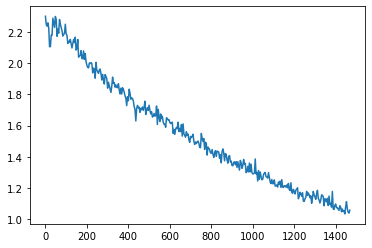


-------------------  without smoother


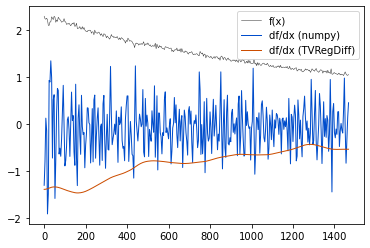


-------------------  with smoother
[-0.00082271 -0.00082351 -0.00082591 -0.00082989 -0.00083546 -0.00084259
 -0.00085126 -0.00086144 -0.0008731  -0.00088618 -0.00090063 -0.00091638
 -0.00093336 -0.00095147 -0.00097057 -0.00099053 -0.0010112  -0.00103241
 -0.00105401 -0.00107586 -0.00109779 -0.00111968 -0.00114137 -0.00116274
 -0.00118366 -0.00120403 -0.00122376 -0.0012428  -0.00126108 -0.00127856
 -0.00129519 -0.00131093 -0.00132574 -0.00133958 -0.00135241 -0.00136417
 -0.00137485 -0.0013844  -0.00139279 -0.00140003 -0.00140609 -0.00141098
 -0.00141471 -0.00141731 -0.00141881 -0.00141926 -0.0014187  -0.0014172
 -0.00141481 -0.0014116  -0.00140763 -0.00140296 -0.00139766 -0.00139178
 -0.00138539 -0.00137855 -0.00137134 -0.00136379 -0.00135598 -0.00134791
 -0.00133964 -0.00133116 -0.0013225  -0.00131366 -0.00130465 -0.00129547
 -0.00128613 -0.00127663 -0.00126697 -0.00125716 -0.0012472  -0.00123711
 -0.00122692 -0.00121666 -0.00120638 -0.00119615 -0.00118602 -0.00117608
 -0.00116637 -0.

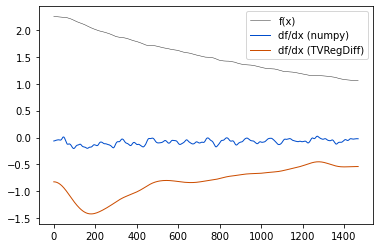

In [17]:
c = ['LituBD5_mass', 'LituLD2_mass', 'LituBL2t_mass', 'LituLL21_mass'][3]
print('\n------------------- test for : {}'.format(c))

X = df[['time_min', c]].dropna(subset = [c])['time_min'].values
Y = df[['time_min', c]].dropna(subset = [c])[c].values
plt.plot(X, Y )
plt.show()
dX = X[1] - X[0]


print('\n-------------------  without smoother')
dYdX = TVRegDiff(data=Y ,itern=20, 
                 alph=100, dx=dX, 
                 ep=1e-9,
                 scale='small' ,
                 plotflag=False, 
                 precondflag=False,
                 diffkernel='abs',
                 cgtol = 1e-4)

plt.plot(X, Y, label='f(x)', c=(0.2, 0.2, 0.2), lw=0.5)
plt.plot(X, np.gradient(Y, dX)*100,
         label='df/dx (numpy)', c=(0, 0.3, 0.8), lw=1)
plt.plot(X, dYdX*1000, label='df/dx (TVRegDiff)',
         c=(0.8, 0.3, 0.0), lw=1)
plt.legend()
plt.show()


print('\n-------------------  with smoother')
Y = lowess(exog = X, endog = Y, frac = 0.05, delta = 0.001 * X.shape[0], return_sorted = False)
dYdX = TVRegDiff(data=Y ,itern=20, 
                 alph=100, dx=dX, 
                 ep=1e-9,
                 scale='small' ,
                 plotflag=False, 
                 precondflag=False,
                 diffkernel='abs',
                 cgtol = 1e-4)
print(dYdX)
plt.plot(X, Y, label='f(x)', c=(0.2, 0.2, 0.2), lw=0.5)
plt.plot(X, np.gradient(Y, dX)*100,
         label='df/dx (numpy)', c=(0, 0.3, 0.8), lw=1)
plt.plot(X, dYdX*1000, label='df/dx (TVRegDiff)',
         c=(0.8, 0.3, 0.0), lw=1)
plt.legend()
plt.show()

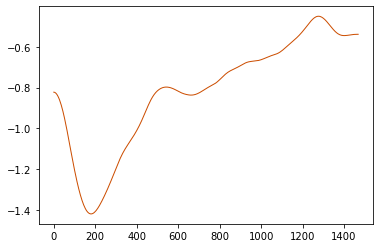

In [340]:
plt.plot(X, dYdX*1000, label='df/dx (TVRegDiff)',
         c=(0.8, 0.3, 0.0), lw=1)

https://github.com/florisvb/PyNumDiff/blob/master/notebooks/1_basic_tutorial.ipynb
https://github.com/florisvb/PyNumDiff
https://github.com/stur86/tvregdiff/issues/2

# Other useful methods

https://link.medium.com/hGdVrrxPabb

https://github.com/arvkevi/kneed

https://stackoverflow.com/questions/28269379/curve-curvature-in-numpy

https://iescoders.com/calculating-the-curvature-of-a-curve/

https://github.com/Pjer-zhang/PJCurvature/blob/master/src/py/PJcurvature_demo.ipynb